# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=5, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   679 (1.1) |   596 (1.1) |    83 (1.0) |
| 1  |   794 (1.3) |   692 (1.3) |   102 (1.2) |
| 2  |   705 (1.1) |   600 (1.1) |   105 (1.3) |
| 3  |   699 (1.1) |   606 (1.1) |    93 (1.1) |
| 4  |   728 (1.2) |   625 (1.2) |   103 (1.2) |
| 5  |   624 (1.0) |   529 (1.0) |    95 (1.1) |
| 6  |   683 (1.1) |   569 (1.1) |   114 (1.4) |
| 7  |   724 (1.2) |   629 (1.2) |    95 (1.1) |
| 8  |   684 (1.1) |   595 (1.1) |    89 (1.1) |
| 9  |   680 (1.1) |   559 (1.1) |   121 (1.5) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,Multidimensional feature,target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",9
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",9
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",4


In [7]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [8]:
# Like any other model, we can define custom dimensions for the bayesian optimization
atom.run(
    models=model,
    metric="f1_weighted",
    n_calls=5,
    bo_params={
        "dimensions": [Categorical([32, 64, 128, 256], name="batch_size")],
        "max_time": 120,
    }
)


Training ========================= >>
Models: NN
Metric: f1_weighted



Running BO for Neural network...
| call             | batch_size | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ---------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |         64 |      0.9674 |           0.9674 | 25.896s |    25.899s |
| Initial point 2  |         64 |      0.9674 |           0.9674 |  0.000s |    26.087s |
| Initial point 3  |        128 |      0.9592 |           0.9674 | 22.819s |    48.962s |
| Initial point 4  |        256 |      0.9462 |           0.9674 | 22.668s |     1m:12s |
| Initial point 5  |         64 |      0.9674 |           0.9674 |  0.001s |     1m:12s |

Results for Neural network:         
Bayesian Optimization ---------------------------
Best call --> Initial point 1
Best parameters --> {'batch_size': 64}
Best evaluation --> f1_weighted: 0.9674
Time elapsed: 1m:12s
Fit ------------------------------------------

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[1.87261177e-13, 1.29779401e-12, 7.28556840e-15, ...,
        3.89982019e-10, 5.59965165e-11, 2.11170994e-11],
       [9.99999762e-01, 2.27971324e-17, 5.66021154e-11, ...,
        6.48891260e-13, 5.04414566e-12, 7.60238805e-09],
       [5.32343170e-10, 3.70767002e-12, 2.30938291e-09, ...,
        3.38590326e-06, 6.84379975e-09, 1.34084672e-02],
       ...,
       [6.66761360e-16, 2.97364062e-14, 5.89494020e-21, ...,
        3.37195782e-20, 1.71077573e-12, 2.51534985e-13],
       [7.00742021e-07, 1.11291320e-14, 5.45523449e-09, ...,
        5.27989891e-12, 2.54416334e-13, 3.96022928e-15],
       [7.01019047e-08, 3.82625442e-12, 7.03115743e-09, ...,
        5.30322495e-06, 9.99876380e-01, 1.05229265e-04]], dtype=float32)

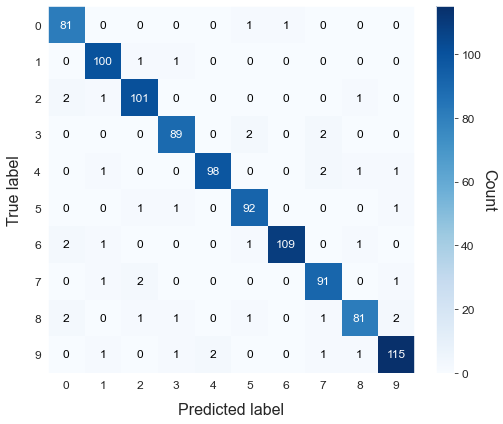

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()